In [69]:
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

## Data Ingestion

In [70]:
filename: str = "../input.csv"
data = []
with open(filename, "r") as input_file:
    csv_reader = csv.reader(input_file, delimiter=',')
    for line in csv_reader:
        data.append(tuple(int(x) for x in line))


## K-Means Clustering

In [71]:
kmeans = KMeans(
    n_clusters=10,
    init='random', 
    n_init=10,
    max_iter=300
)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

## 1-NN to Centroids from Input Data

In [79]:
knn = NearestNeighbors(n_neighbors=1, radius=100)
knn.fit(data)
neighbors_idx = knn.kneighbors(centroids, n_neighbors=1, return_distance=False)

In [80]:
closest_points = list(set(data[x[0]] for x in neighbors_idx))

## Plotting

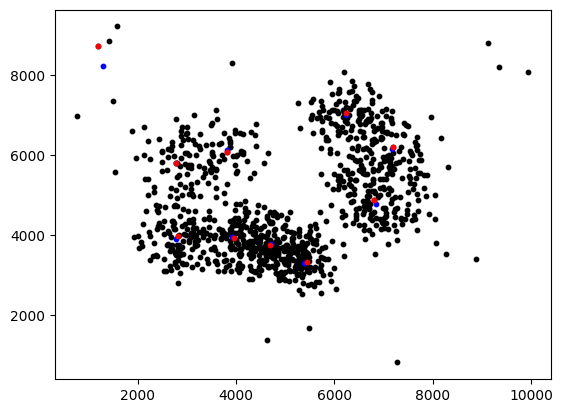

In [81]:
plt.scatter(
    [x[0] for x in data], 
    [y[1] for y in data], 
    s=10,
    color='k'
)

plt.scatter(
    [x[0] for x in centroids], 
    [y[1] for y in centroids], 
    s=10,
    color='b'
)

plt.scatter(
    [x[0] for x in closest_points], 
    [y[1] for y in closest_points], 
    s=10,
    color='r'
)

plt.show()